## Char RNN Text Generation

In [1]:
import torch

### Load Data

In [2]:
dataset_path = "../data/anna.txt"
with open(dataset_path, "r") as f:
    data = f.read()

In [3]:
data[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

In [4]:
all_chars = tuple(set(data)) # get all characters used in the text

In [5]:
vocab_size = len(all_chars) # number of unique characters
vocab_size

83

In [6]:
int2char = {idx: char for idx, char in enumerate(all_chars)}
char2int = {char: idx for idx, char in int2char.items()}

In [7]:
data_encoded = [char2int[char] for char in data] # convert all chars in the text into int representations

In [8]:
data_encoded[:15]

[13, 16, 71, 79, 5, 82, 78, 77, 1, 20, 20, 20, 29, 71, 79]

### One Hot Encoding
Since the vocab size is small, we can proceed with one hot encoding instead of embeddings

In [9]:
def one_hot_encode_batch(input_batch, vocab_size):
    '''
    perform one hot encoding on a sequence batch
    
    input_batch - a 2D tensor containing encoded character sequence batch
        shape  : (batch_size, sequence_length)
        example: torch.tensor([[1, 2, 3, 4],
                               [34, 23, 2, 8]])
                               
    vocab_size - number of unique characters in the vocabulary; 
                 This will be the size of the character vector
    '''
    batch_size = input_batch.size(0)
    sequence_length = input_batch.size(1)
    
    result = torch.zeros((batch_size, sequence_length, vocab_size), dtype=torch.float32)
    
    for i in range(batch_size):
        char_indices = input_batch[i]
        char_indices.unsqueeze_(-1)
    
        # one hot encode
        result[i].scatter_(1, char_indices, 1)
    
    return result

In [10]:
a_batch = torch.tensor([[3, 7, 5, 2],
                        [1, 6, 4, 8]])

In [11]:
out = one_hot_encode_batch(a_batch, vocab_size=10)

In [12]:
print(out.shape, "\n")
out

torch.Size([2, 4, 10]) 



tensor([[[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]]])

### Batching the Data
Refer to the diagram below to see how the data is batched

In [13]:
from PIL import Image

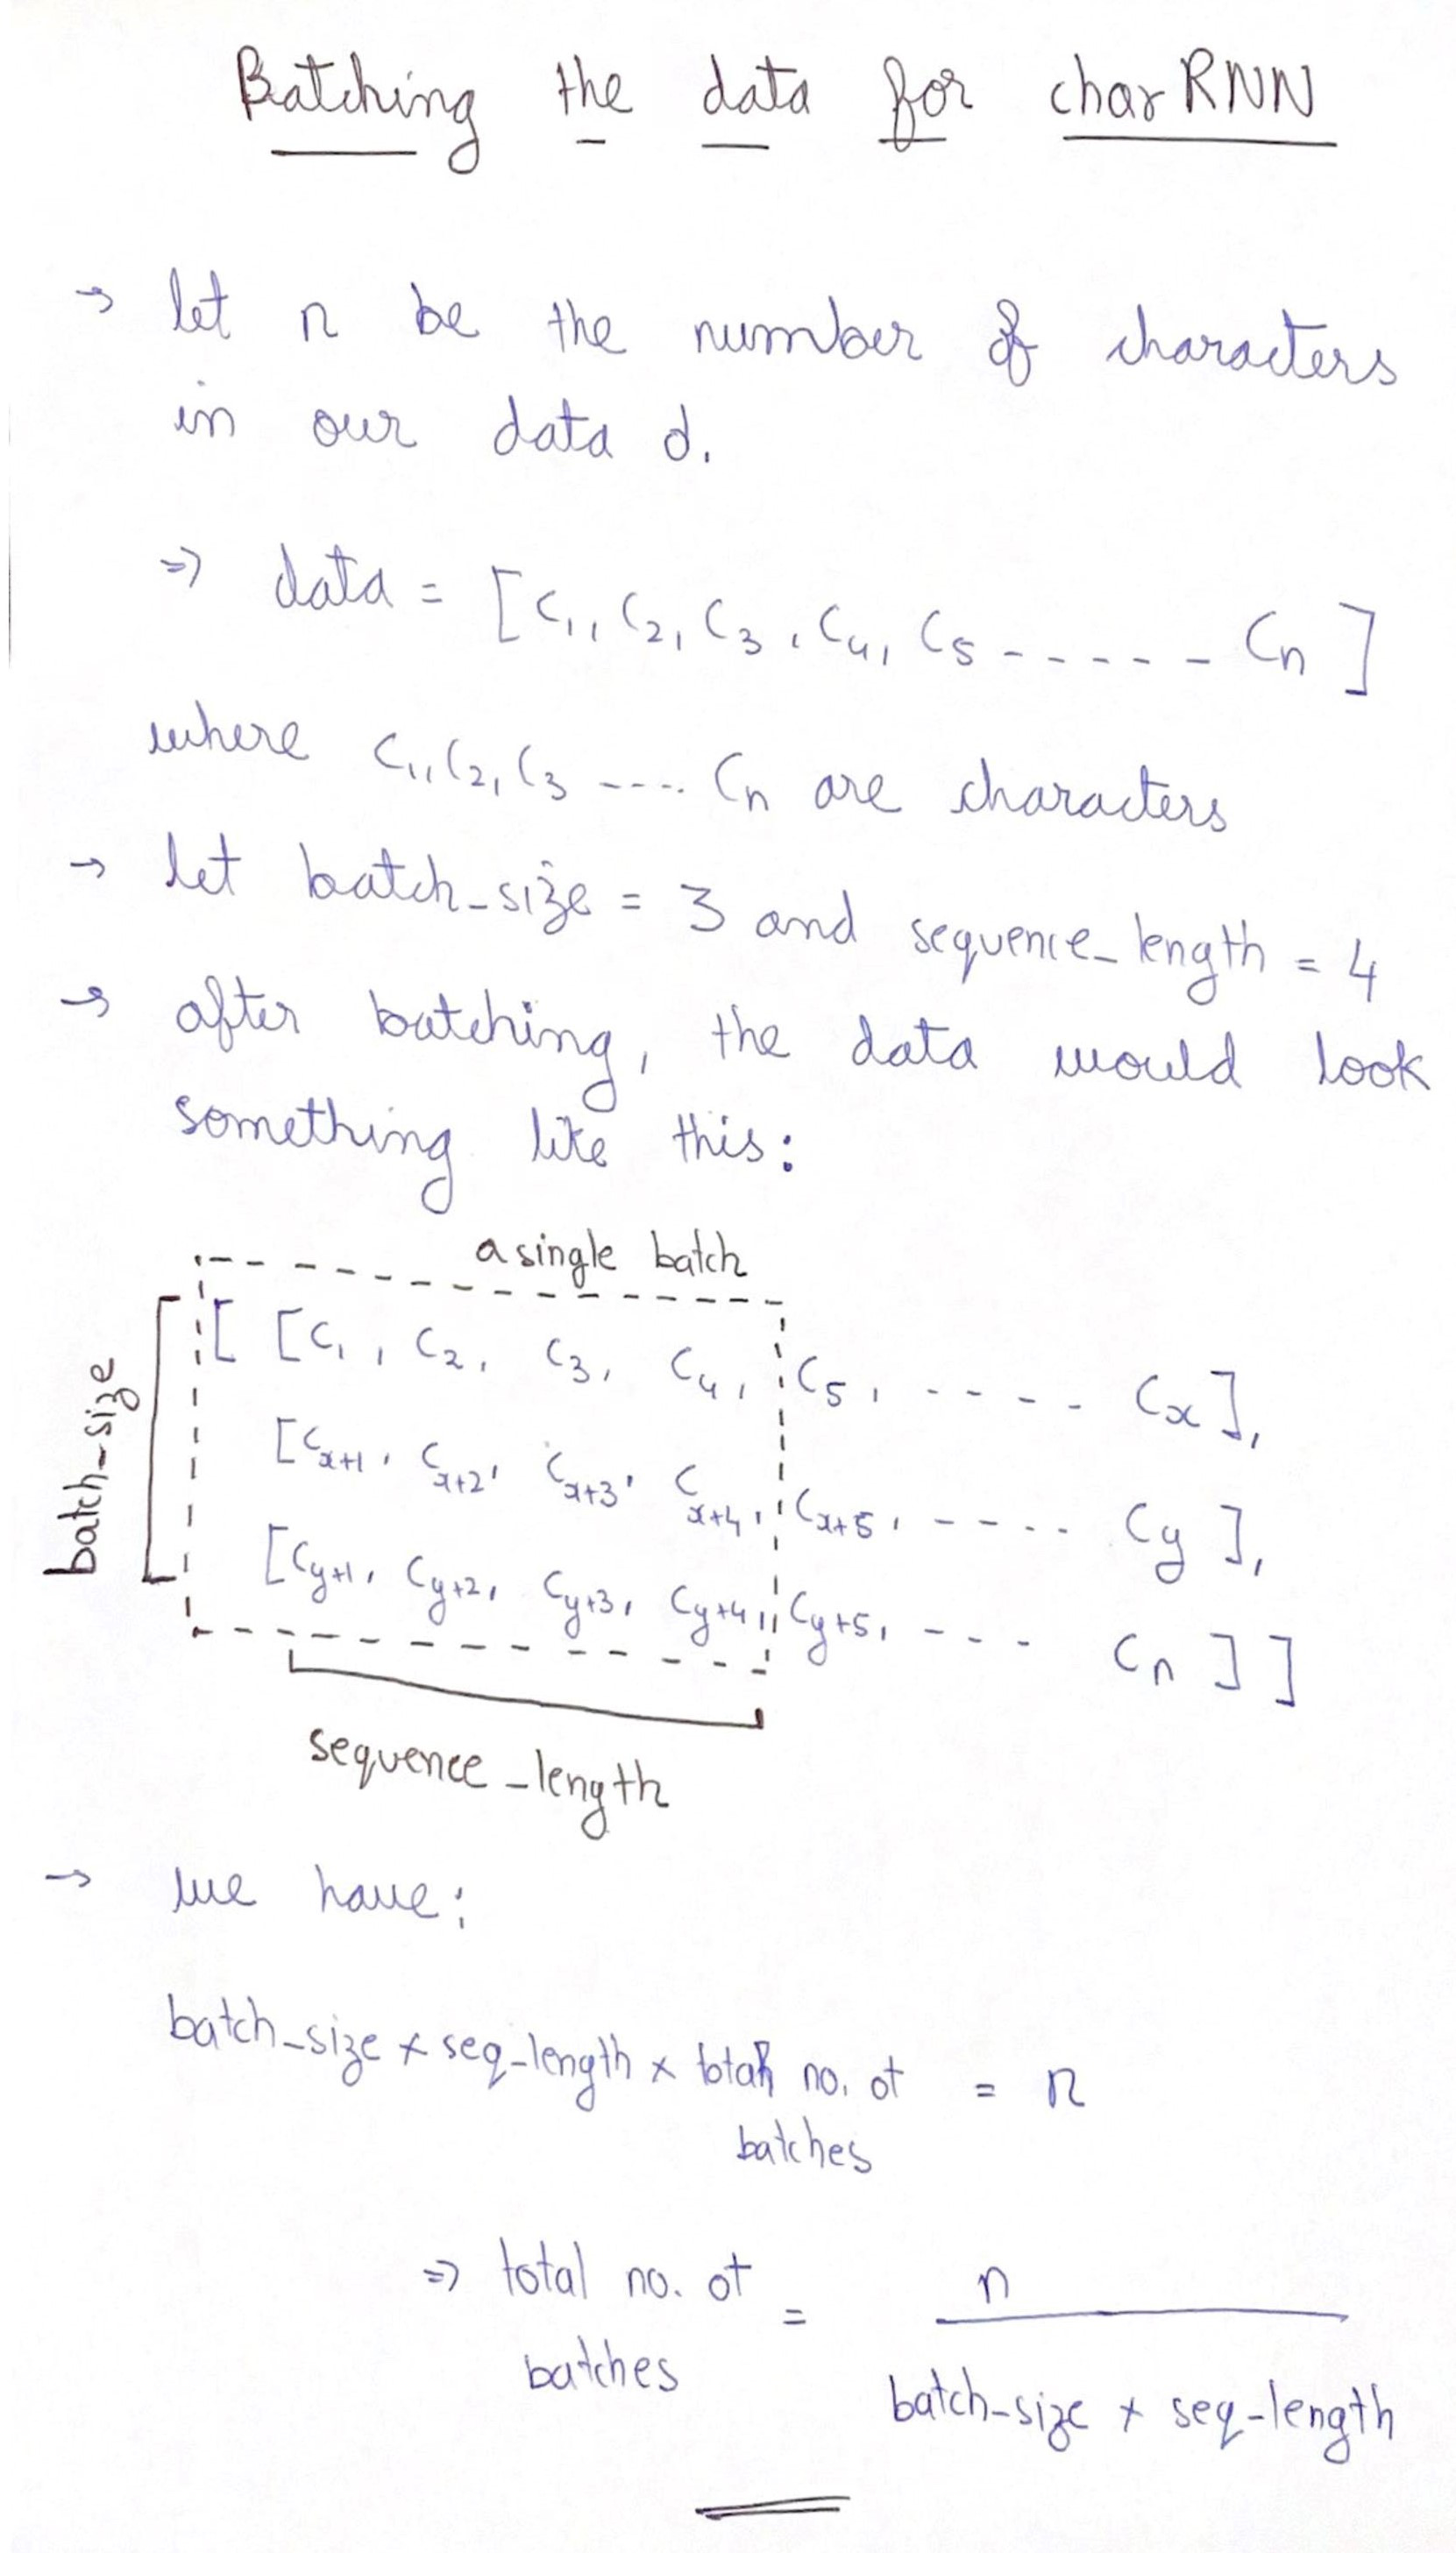

In [14]:
Image.open("charRNN_batching.jpg")

In [15]:
def get_batches(arr, batch_size, sequence_length):
    n_chars = arr.size(0) # get the total number of characters
    n_batches = n_chars // (batch_size * sequence_length) # get the number of batches that can be made
    
    # remove the leftover characters that cannot fit into any batch
    arr = arr[:n_batches * batch_size * sequence_length]
    
    # reshape the data as shown in the diagram
    arr = arr.view(batch_size, -1)
    
    for idx in range(0, arr.size(1), sequence_length):
        X = arr[:, idx: idx + sequence_length]
        Y = torch.zeros((batch_size, sequence_length), dtype=torch.int64)
        
        try:
            Y[:, :-1] = X[:, 1:]
            Y[:, -1] = X[:, idx + sequence_length]
            
        except IndexError:
            Y[:, :-1] = X[:, 1:]
            Y[:, -1] = X[:, 0]
        
        yield X, Y

In [16]:
data_encoded_tensor = torch.tensor(data_encoded, dtype=torch.int64)

In [17]:
batches = get_batches(data_encoded_tensor, 8, 50)

In [18]:
x, y = next(batches)

In [19]:
# printing out the first 10 items in a sequence
print('x\n', x[:, :10])
print('\ny\n', y[:, :10])

x
 tensor([[13, 16, 71, 79,  5, 82, 78, 77,  1, 20],
        [39, 64, 70, 77,  5, 16, 71,  5, 77, 71],
        [82, 70, 81, 77, 64, 78, 77, 71, 77,  3],
        [39, 77,  5, 16, 82, 77, 37, 16, 33, 82],
        [77, 39, 71, 35, 77, 16, 82, 78, 77,  5],
        [37, 69, 39, 39, 33, 64, 70, 77, 71, 70],
        [77, 31, 70, 70, 71, 77, 16, 71, 81, 77],
        [14, 22, 62, 64, 70, 39, 18, 34, 19, 77]])

y
 tensor([[16, 71, 79,  5, 82, 78, 77,  1, 20, 20],
        [64, 70, 77,  5, 16, 71,  5, 77, 71,  5],
        [70, 81, 77, 64, 78, 77, 71, 77,  3, 64],
        [77,  5, 16, 82, 77, 37, 16, 33, 82,  3],
        [39, 71, 35, 77, 16, 82, 78, 77,  5, 82],
        [69, 39, 39, 33, 64, 70, 77, 71, 70, 81],
        [31, 70, 70, 71, 77, 16, 71, 81, 77, 39],
        [22, 62, 64, 70, 39, 18, 34, 19, 77, 58]])


### Build the Model

In [20]:
import torch.nn as nn

In [21]:
class charRNN(nn.Module):
    
    def __init__(self, VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS=2, P_DROPOUT=0.5):
        super().__init__()
        self.HIDDEN_SIZE = HIDDEN_SIZE
        self.N_LAYERS = N_LAYERS
        self.lstm = nn.LSTM(VOCAB_SIZE, HIDDEN_SIZE, batch_first=True, 
                            dropout=P_DROPOUT, num_layers=N_LAYERS)
        self.dropout = nn.Dropout(P_DROPOUT)
        self.fc = nn.Linear(HIDDEN_SIZE, VOCAB_SIZE)
        
    def forward(self, inputs, hidden):
        lstm_out, hidden = self.lstm(inputs, hidden)
        
        out = self.dropout(lstm_out)
        
        # we stack all the intermediate hidden state outputs
        # and pass it to a fully connected layer
        out = out.contiguous().view(-1, self.HIDDEN_SIZE)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, BATCH_SIZE):
        hidden = (torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).cuda(),
                  torch.zeros((self.N_LAYERS, BATCH_SIZE, self.HIDDEN_SIZE), dtype=torch.float32).cuda())
        return hidden

In [22]:
BATCH_SIZE=128
SEQ_LENGTH = 100

VOCAB_SIZE=vocab_size
HIDDEN_SIZE=512
N_LAYERS=2

In [23]:
model = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS)

#### Check model Parameters
According to the official notebook, if the dataset size is n MB, then there should approximately be n million parameters. In our case, the dataset size is 1.93 MB

In [24]:
# count the number of parameters
sum([p.numel() for p in model.parameters()])

3366483

#### test inference

In [25]:
sample_chars = torch.randint(0, VOCAB_SIZE, (BATCH_SIZE, SEQ_LENGTH))

In [26]:
sample_chars_one_hot_encoded = one_hot_encode_batch(sample_chars, VOCAB_SIZE)

In [27]:
sample_chars_one_hot_encoded.shape

torch.Size([128, 100, 83])

In [28]:
hidden = (torch.zeros((N_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float32),
          torch.zeros((N_LAYERS, BATCH_SIZE, HIDDEN_SIZE), dtype=torch.float32))

In [29]:
out, hidden = model(sample_chars_one_hot_encoded, hidden)

In [30]:
out.shape

torch.Size([12800, 83])

In [31]:
weight = next(model.parameters())

In [32]:
assert model.lstm.weight_ih_l0.shape == weight.shape

### Train the Model

In [33]:
device = torch.device('cuda')

In [34]:
model.to(device=device)

charRNN(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)

In [35]:
import torch.optim as optim

In [36]:
n_epochs = 33
optimizer = optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
clip = 5

#### Create Train, Val Data

In [37]:
data = torch.tensor(data_encoded, dtype=torch.int64)

In [38]:
val_percent = 0.2
n_val = int(val_percent * len(data))
n_train = len(data) - n_val
print(f"train: {n_train}, val: {n_val}")

train: 1588179, val: 397044


In [39]:
data_train = data[:n_train]
data_val = data[n_train:]

#### Training the Model

In [40]:
from tqdm import tqdm

In [41]:
train_loss_list = []
val_loss_list = []

for epoch in tqdm(range(n_epochs)):
    
    # training
    
    n_batches_train = 0
    cummulative_loss_train = 0 
    
    # set model to training mode
    model.train()
    
    # initialize hidden state
    hidden = model.init_hidden(BATCH_SIZE)
    
    # get batches at every epoch as this is a generator
    for x, y in get_batches(data_train, BATCH_SIZE, SEQ_LENGTH):
        
        inputs = one_hot_encode_batch(x, vocab_size)
        targets = y
        
        inputs = inputs.to(device=device)
        targets = targets.to(device=device)
        
        # detach the hidden state before passing to the model
        hidden_train = tuple([h.detach() for h in hidden])
        
        preds, hidden = model(inputs, hidden_train)
        
        # the targets were created with dtype int64, convert to float32
        loss_train = loss(preds, targets.view(BATCH_SIZE*SEQ_LENGTH).long())
        
        optimizer.zero_grad()
        loss_train.backward()
        
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        n_batches_train += 1
        cummulative_loss_train += loss_train.item()
        
    loss_per_epoch_train = cummulative_loss_train / n_batches_train
        
    # validation
    
    n_batches_val = 0
    cummulative_loss_val = 0 
    
    model.eval()
    
    hidden = model.init_hidden(BATCH_SIZE)
    
    for x, y in get_batches(data_val, BATCH_SIZE, SEQ_LENGTH):
        
        inputs = one_hot_encode_batch(x, vocab_size)
        targets = y
        
        inputs = inputs.to(device=device)
        targets = targets.to(device=device)
        
        val_hidden = tuple([h.detach() for h in hidden])
        
        with torch.no_grad():
            preds, hidden = model(inputs, val_hidden)
            val_loss = loss(preds, targets.view(BATCH_SIZE*SEQ_LENGTH).long())
            
        n_batches_val += 1
        cummulative_loss_val += val_loss.item()
            
    loss_per_epoch_val = cummulative_loss_val / n_batches_val
    
    train_loss_list.append(loss_per_epoch_train)
    val_loss_list.append(loss_per_epoch_val)
        
    # print(f"epoch: {epoch},\ntrain_loss: {loss_per_epoch_train},\nval_loss: {loss_per_epoch_val}")
    

100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [20:50<00:00, 37.90s/it]


#### Plotting the loss

In [43]:
import matplotlib.pyplot as plt

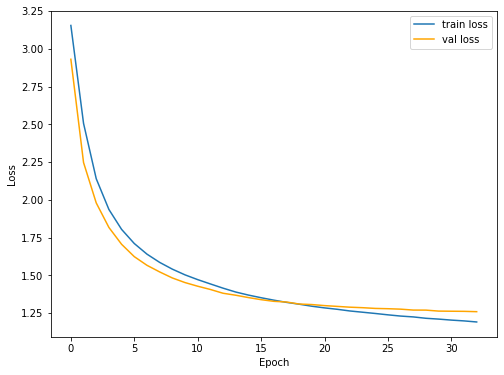

In [44]:
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

axes.plot(list(range(n_epochs)), train_loss_list, label="train loss")
axes.plot(list(range(n_epochs)), val_loss_list, color='orange', label="val loss")

axes.set_xlabel("Epoch")
axes.set_ylabel("Loss")

plt.legend()

Perfect Curve

#### Saving the Model

In [45]:
model_name = "char_rnn_epoch_33_dropout_0.5.pt"

In [46]:
torch.save(model.state_dict(), model_name)

#### Loading the Model

In [47]:
model_loaded = charRNN(VOCAB_SIZE, HIDDEN_SIZE, N_LAYERS)

In [48]:
model_loaded.load_state_dict(torch.load(model_name))

<All keys matched successfully>

### Predict
Everything would be carried out on a gpu

In [49]:
import torch.nn.functional as F
import numpy as np

In [50]:
def predict(model, hidden, input_char, k, device):
    '''
    given a single input_char, get the probability distribution of the output chars,
    and pick any char from the top k chars in the distribution
    '''
    
    # encode input char
    char_encoded = torch.tensor([char2int[input_char]])
    char_encoded.unsqueeze_(0)
    
    # one-hot encode char
    char_one_hot = one_hot_encode_batch(char_encoded, vocab_size)
    char_one_hot = char_one_hot.to(device=device)
    
    # detach hidden state
    hidden = tuple([h.detach() for h in hidden])
    
    # get the outputs
    out, hidden = model(char_one_hot, hidden)
    
    # convert the output to a character probability distribution
    p = F.softmax(out, dim=1).detach()
    
    # move to cpu as numpy doesn't support gpu
    p = p.cpu()
    
    # get top k characters from the distribution
    values, indices = p.topk(k)
    
    indices = indices.squeeze().numpy()
    values = values.squeeze().numpy()
    
    # sample any char from the top k chars using the output softmax distribution
    char_pred = np.random.choice(indices, size=1, p=values/values.sum())
    
    return int2char[char_pred[0]], hidden

In [51]:
def generate_text(model, n_chars, prime, k, device):
    batch_size = 1
    
    chars = [char for char in prime]
    hidden = model.init_hidden(batch_size)
    
    # build up the hidden state using the initial prime
    for char in prime:
        char_pred, hidden = predict(model, hidden, char, k, device)
        
    chars.append(char_pred)
    
    # generate n chars
    for i in range(n_chars):
        char_pred, hidden = predict(model, hidden, chars[-1], k, device)
        chars.append(char_pred)
        
    return "".join(chars)

In [52]:
device = torch.device('cuda')

In [53]:
model_loaded.to(device=device)

charRNN(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)

In [54]:
model_loaded.eval()

charRNN(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)

In [58]:
prime="Once upon a time"
k = 5
n_chars = 2000

In [59]:
text = generate_text(model, n_chars, prime, k, device)

In [60]:
text

'Once upon a time.\n\n"This were in success."\n\n"No, this is through the matter to them to me wonse for my feeling. I\'m a\npretension of my carriage."\n\n"Well, I\'m not going, and I won\'t be in the made.\n\n"I\'ll say about your hand." But the conversation he went up to his wife.\nHere was they would not go away, and winging to all. She was not, as he\ncould not have said that his wife had been trying to discover him, but\nhe could not have to drunk in his brother\'s face, and seemed at once\ntaken again, she herself went on still more and made her feeling and did not, that\nhe had back her heart so much. Her feet. He was alroad in a steather in a\nshade words and a corture of his heart to herself.\n\n"Ah, I\'m touching to you," she added, and he was sorry and the\npaper--shall waiting to share her arrively to his hat. And the\ncarriage and her head and she went to by somewhere as they he had the\nsame time he could not ask him; but the point would be desciret on a\nplincing, as a 

In [61]:
# save the text file
with open("generated_text_out.txt", "w") as f:
    f.write(text)